<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#UAPs-and-Extreme-Simplicity-Bias:-Slab-structured-data" data-toc-modified-id="UAPs-and-Extreme-Simplicity-Bias:-Slab-structured-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>UAPs and Extreme Simplicity Bias: Slab-structured data</a></span><ul class="toc-item"><li><span><a href="#Evaluating-UAPs-of-FCNs-trained-on-LMS-5-(Linear-+-multiple-5-Slabs)-data" data-toc-modified-id="Evaluating-UAPs-of-FCNs-trained-on-LMS-5-(Linear-+-multiple-5-Slabs)-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Evaluating UAPs of FCNs trained on LMS-5 (Linear + multiple 5-Slabs) data</a></span></li><li><span><a href="#Evaluating-UAPs-of-FCNs-trained-on-MS-(5,7)-(5-Slab-+-Multiple-7-Slabs)-data" data-toc-modified-id="Evaluating-UAPs-of-FCNs-trained-on-MS-(5,7)-(5-Slab-+-Multiple-7-Slabs)-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Evaluating UAPs of FCNs trained on MS-(5,7) (5-Slab + Multiple 7-Slabs) data</a></span></li></ul></li></ul></div>

# UAPs and Extreme Simplicity Bias: Slab-structured data
Recall that we define extreme simplicity bias (SB) as the tendency of neural networks trained with SGD or variants to learn a small-margin classifier that exclusively relies on the simplest feature and remain invariant to all complex features. 
 
In this notebook, we demonstrate the extreme nature of SB on slab-structured datasets can result in instance-specific PGD adversarial perturbations and data-agnostic universal adversarial perturbations that only attack the "simple" feature on which the trained model exclusively relies on.  

We evaluate UAPs of fully-connected networks (FCNs) trained on LMS-5 and MS-(5,7) datasets; the datasets are described in Section 3 and Section 4 of the [paper](https://arxiv.org/abs/2006.07710) respectively. In LMS-5 and MS-(5,7), the simplest feature corresponds to the linear and 5-slab block whereas the complex features correspond to the 5-slab and 7-slab blocks respectively. We validate this phenomenon using the metrics defined in Section 3 of the [paper](https://arxiv.org/abs/2006.07710). Please see section 4.3 of the [paper](https://arxiv.org/abs/2006.07710) for similar results on the MNIST-CIFAR dataset.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imports import *

DEVICE_ID = 0 # GPU_ID or None (CPU)
DEVICE = gu.get_device(DEVICE_ID)

## Evaluating UAPs of FCNs trained on LMS-5 (Linear + multiple 5-Slabs) data

Text(0.5, 0.98, 'LMS')

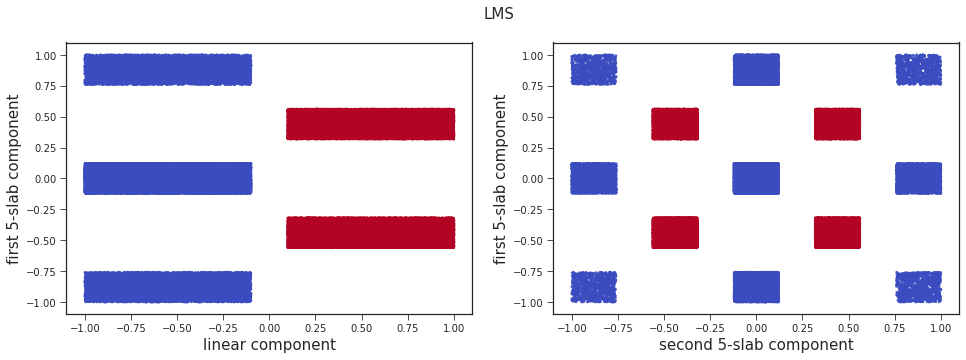

In [68]:
# load and visualize LMS data

c = config =  {
    'num_train': 100_000, # training dataset size
    'dim': 50, # input dimension
    'lin_margin': 0.1, # linear margin
    'slab_margin': 0.1, # slab margin,
    'same_margin': True, # keep same margin
    'random_transform': True, # apply random (orthogonal) transformation
    'width': 1, # data width in standard basis
    'num_lin': 1, # number of linear components
    'num_slabs': 49, #. number of 5 slabs
    'num_slabs7': 0, # number of 7 slabs
    'num_slabs3': 0, # number of 3 slabs
    'bs': 256, # batch size
    'corrupt_lin': 0.0, # p_noise
    'corrupt_lin_margin': True, # noise model
    'corrupt_slab': 0.0, # slab corruption
    'num_test': 10_000, # test dataset size
    'hdim': 200, # model width
    'hl': 1, # model depth
    'mtype': 'fcn', # model architecture
    'device': gu.get_device(DEVICE_ID), # GPU device
    'lr': 0.1, # step size
    'weight_decay': 5e-4 # weight decay
}

data = get_data(**c)

# visualize LMS data
fig, (ax, ax_) = plt.subplots(1,2,figsize=(16, 5))
W = data['W']
X, Y = data['X'], data['Y']
X = X.numpy().dot(W.T)
ax.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) 
ax.set_xlabel('linear component', fontsize=15)
ax.set_ylabel('first 5-slab component', fontsize=15)

ax_.scatter(X[:,2], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) 
ax_.set_xlabel('second 5-slab component', fontsize=15)
ax_.set_ylabel('first 5-slab component', fontsize=15)
fig.suptitle('LMS', fontsize=15)

In [69]:
# train FCN on LMS data
model = synth_models.get_fcn(idim=c['dim'], hdim=c['hdim'], odim=2, hl=c['hl']).to(c['device'])
opt = optim.SGD(model.parameters(), lr=c['lr'], weight_decay=c['weight_decay'])

stats = utils.fit_model(model, F.cross_entropy, opt, data['tr_dl'], 
                        data['te_dl'], gap=1000, device=c['device'],
                        epsilon=0.01, patience_updates=1, is_loss_epsilon=True)

accuracy/loss measured every 1000 updates
update_print_gap: 1000, epss: 0.01, bs: 256, device: cuda:0
#updates, train acc, test acc, train loss
0 0.5033 0.5089 0.6945
1000 1.0000 1.0000 0.0113
2000 1.0000 1.0000 0.0059
converged after 5 epochs in 0.0m 9.321151s, gap: 0.0
init-ing patience (1 updates)
2001 1.0000 1.0000 0.0059


In [70]:
# compute standard, S-randomized and S^c-randomized AUC 
std_auc = utils.get_binary_auc(model, data['te_dl'], c['device'])

# get S-randomized and S^c-randomized datasets 
s_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], [0]) # randomize linear coordinate
sc_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], list(range(1, c['dim']))) # randomize all 49 5-slab coordinates

# compute randomized AUC
s_rand_auc = utils.get_binary_auc(model, s_rand_dl, c['device']) 
sc_rand_auc = utils.get_binary_auc(model, sc_rand_dl, c['device']) 

print ('Standard AUC: {:.3f}'.format(std_auc))
print ('Linear-Randomized or S-Randomized AUC: {:.3f}'.format(s_rand_auc))
print ('Slabs-Randomized or Sc-Randomized AUC: {:.3f}'.format(sc_rand_auc))

Standard AUC: 1.000
Linear-Randomized or S-Randomized AUC: 0.491
Slabs-Randomized or Sc-Randomized AUC: 1.000


Coordinate-wise randomized accuracies:
0:0.507 1:1.000 2:1.000 3:1.000 4:1.000 5:1.000 6:1.000 7:1.000 8:1.000 9:1.000 10:1.000 11:1.000 12:1.000 13:1.000 14:1.000 15:1.000 16:1.000 17:1.000 18:1.000 19:1.000 20:1.000 21:1.000 22:1.000 23:1.000 24:1.000 25:1.000 26:1.000 27:1.000 28:1.000 29:1.000 30:1.000 31:1.000 32:1.000 33:1.000 34:1.000 35:1.000 36:1.000 37:1.000 38:1.000 39:1.000 40:1.000 41:1.000 42:1.000 43:1.000 44:1.000 45:1.000 46:1.000 47:1.000 48:1.000 49:1.000 



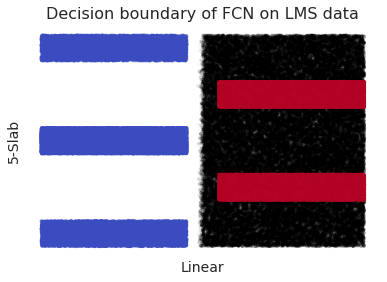

In [71]:
"""
Two-dimensional projection of the model's decision boundary
onto the two most influential coordinates (measured using randomized AUC)
"""
print ("Coordinate-wise randomized accuracies:")
ax = lms_utils.visualize_boundary(model, data, 0, 1, 50, ax=None, is_binary=False, 
                                  width=1, unif_k=True, k=100_000, print_info=True)
utils.update_ax(ax, 'Decision boundary of FCN on LMS data', 'Linear', '5-Slab', 
                title_fs=16, label_fs=14, legend_loc=False)
sns.despine(ax=ax, bottom=True, left=True); ax.set_xticks([]); ax.set_yticks([])
None

Accuracy on Perturbed Data: 0.00000
Mean Fraction of Budget in Linear Coordinate: 0.99732


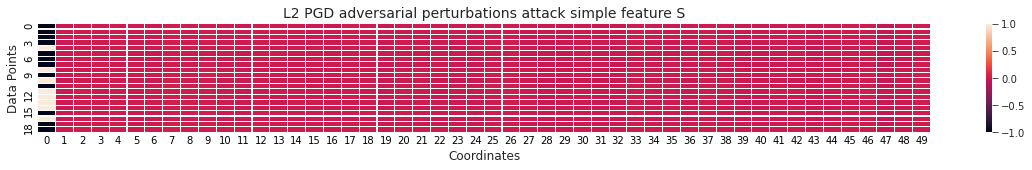

In [72]:
"""
Instance-specific adversarial attack (e.g., L2 PGD perturbations)
exclusively perturb feature S (linear coordinate in LMS) 
"""
# compute perturbation
bounds = (data['X'].min().item(), data['X'].max().item())
drange = bounds[1]-bounds[0]
attack = pu.L2_PGD_Attack(0.5*drange, 0.05*drange, 20, 'untargeted', device=DEVICE, bounds=bounds)
attack_eval = attack.evaluate_attack(data['te_dl'], model)

# rotate perturbation and visualize mass in each coordinate(undo random transformation)
P = attack_eval['P'].dot(W.T)
Pn = P/np.max(np.abs(P), axis=1).reshape(-1,1)

# budget in linear
linear_ratio = np.abs(P[:,0])/np.linalg.norm(P, axis=1)

print ("Accuracy on Perturbed Data: {:.5f}".format(attack_eval['acc']))
print ("Mean Fraction of Budget in Linear Coordinate: {:.5f}".format(np.mean(linear_ratio)))

fig, ax = plt.subplots(1,1,figsize=(20,2))
sns.heatmap(Pn[:20], linewidth=0.1, ax=ax) 
utils.update_ax(ax, 'L2 PGD adversarial perturbations attack simple feature S', 'Coordinates', 'Data Points', despine=False, legend_loc=False)

Accuracy on Perturbed Data: 0.00660
Mean Fraction of Budget in Linear Coordinate: 0.99732


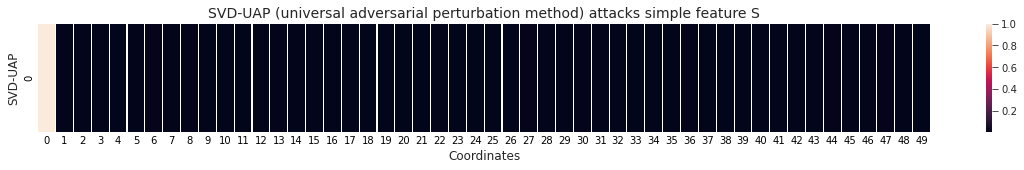

In [73]:
"""
Instance-agnostic "universal" adversarial perturbations exclusively attacks 
the simple feature S (linear coordinate in LMS) as well. We show that 
SVD UAPs (https://arxiv.org/abs/2005.08632) and AS UAPs (Algorithm 2 in https://arxiv.org/abs/1811.11304)
"""

# SVD UAP (https://arxiv.org/abs/2005.08632)
bounds = (data['X'].min().item(), data['X'].max().item())
drange = bounds[1]-bounds[0]
attack = pu.L2_PGD_Attack(1.0*drange, 0.05*drange, 30, 'untargeted', device=DEVICE, bounds=bounds)
svd_uap = pu.SVD_UAP(attack, bounds=bounds, device=DEVICE)
svd_uap.fit(data['te_dl'], model)
attack_eval = svd_uap.evaluate_attack(data['te_dl'], model, eps=1.0)

# analyze UAP
UAP = svd_uap.uap.dot(W.T)
UAPn = np.abs(UAP)/np.max(np.abs(UAP))

print ("Accuracy on Perturbed Data: {:.5f}".format(attack_eval['acc']))
print ("Mean Fraction of Budget in Linear Coordinate: {:.5f}".format(np.mean(linear_ratio)))

fig, ax = plt.subplots(1,1,figsize=(20,2))
sns.heatmap(UAPn.reshape(1,-1), linewidth=0.1, ax=ax) 
utils.update_ax(ax, 'SVD-UAP (universal adversarial perturbation method) attacks simple feature S', 'Coordinates', 'SVD-UAP', despine=False, legend_loc=False)

Accuracy on Perturbed Data: 0.00660
Mean Fraction of Budget in Linear Coordinate: 0.99732


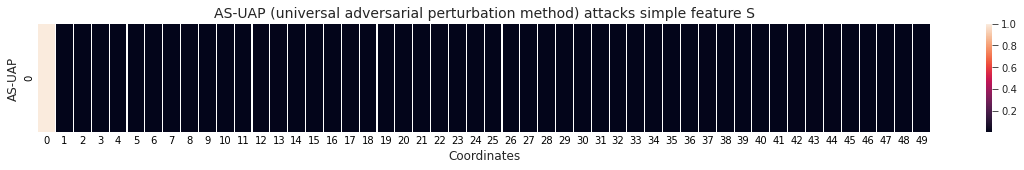

In [75]:
# AS UAP (https://arxiv.org/abs/1811.11304)
bounds = (data['X'].min().item(), data['X'].max().item())
drange = bounds[1]-bounds[0]

as_uap = pu.L2_AS_UAP(1.0, 0.05, 30, (50,), bounds=bounds, device=DEVICE)
as_uap.fit(data['te_dl'], model, num_epochs=2)
attack_eval = as_uap.evaluate_attack(data['te_dl'], model)

# analyze UAP
UAP = as_uap.uap.dot(W.T)
UAPn = np.abs(UAP)/np.max(np.abs(UAP))

print ("Accuracy on Perturbed Data: {:.5f}".format(attack_eval['acc']))
print ("Mean Fraction of Budget in Linear Coordinate: {:.5f}".format(np.mean(linear_ratio)))

fig, ax = plt.subplots(1,1,figsize=(20,2))
sns.heatmap(UAPn.reshape(1,-1), linewidth=0.1, ax=ax) 
utils.update_ax(ax, 'AS-UAP (universal adversarial perturbation method) attacks simple feature S', 'Coordinates', 'AS-UAP', despine=False, legend_loc=False)

As shown above, L2 PGD perturbations and data-agnostic UAPs (computed using SVD-UAP and AS-UAP) drive down the accuracy from $100\%$ to $0\%$ by only targeting the simpler linear coordinate on which trained models exclusively rely on (due to extreme SB).

## Evaluating UAPs of FCNs trained on MS-(5,7) (5-Slab + Multiple 7-Slabs) data

Text(0.5, 0.98, 'MS-(5,7) data')

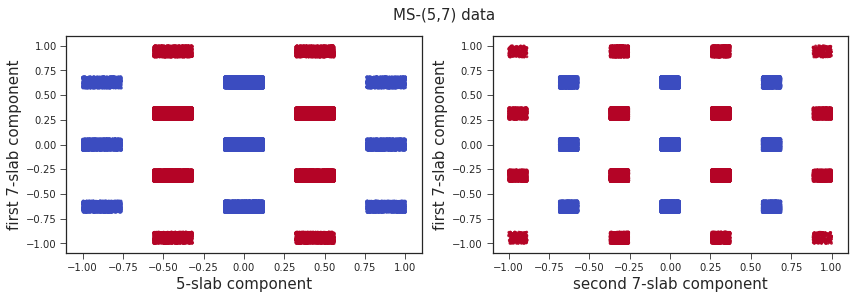

In [2]:
c = config =  {
    'num_train': 100_000, # training dataset size
    'dim': 50, # input dimension
    'lin_margin': 0.1, # linear margin
    'slab_margin': 0.1, # slab margin,
    'same_margin': True, # keep same margin
    'random_transform': True, # apply random transform
    'width': 1, # data width
    'num_lin': 0, # number of linear components
    'num_slabs': 1, #. number of 5-slabs
    'num_slabs7': 49, # number of 7-slabs
    'num_slabs3': 0, # number of 3-slabs
    'bs': 256, # batch size
    'corrupt_lin': 0.0, # p_noise
    'corrupt_lin_margin': True, # noise model
    'corrupt_slab': 0.0, # slab corruption
    'num_test': 5_000, # test dataset size
    'hdim': 200, # model width
    'hl': 1, # model depth
    'mtype': 'fcn', # model architecture
    'device': gu.get_device(DEVICE_ID), # GPU device
    'lr': 0.1, # step size
    'weight_decay': 5e-4 # weight decay
}

data = get_data(**c)

# visualize noisy LMS
fig, (ax, ax_) = plt.subplots(1,2,figsize=(14, 4))
W = data['W']
X, Y = data['X'], data['Y']
X = X.numpy().dot(W.T)
ax.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
ax.set_xlabel('5-slab component', fontsize=15)
ax.set_ylabel('first 7-slab component', fontsize=15)

ax_.scatter(X[:,2], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
ax_.set_xlabel('second 7-slab component', fontsize=15)
ax_.set_ylabel('first 7-slab component', fontsize=15)
fig.suptitle('MS-(5,7) data', fontsize=15)

In [4]:
# train FCN on MS-(5,7) data
model = synth_models.get_fcn(idim=c['dim'], hdim=c['hdim'], odim=2, hl=c['hl']).to(c['device'])
opt = optim.SGD(model.parameters(), lr=c['lr'], weight_decay=c['weight_decay'])

stats = utils.fit_model(model, F.cross_entropy, opt, data['tr_dl'], 
                        data['te_dl'], gap=5000, device=c['device'],
                        epsilon=0.01, patience_updates=1000)

accuracy/loss measured every 5000 updates
update_print_gap: 5000, epss: 0.01, bs: 256, device: cuda:0
#updates, train acc, test acc, train loss
0 0.4988 0.5010 0.6952
5000 0.5292 0.4994 0.6917
10000 0.7875 0.7650 0.6458
15000 1.0000 1.0000 0.0297
converged after 38 epochs in 0.0m 47.581409s, gap: 0.0
init-ing patience (1000 updates)
16000 1.0000 1.0000 0.0249


In [5]:
# compute standard, S-randomized and S^c-randomized AUC 
std_auc = utils.get_binary_auc(model, data['te_dl'], c['device'])

# get S-randomized and S^c-randomized datasets
s_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], [0]) # randomize 5-slab coordinate
sc_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], list(range(1, c['dim']))) # randomize all 49 7-slab coordinates

# compute randomized AUC
s_rand_auc = utils.get_binary_auc(model, s_rand_dl, c['device']) 
sc_rand_auc = utils.get_binary_auc(model, sc_rand_dl, c['device']) 

print ('Standard AUC: {:.3f}'.format(std_auc))
print ('(5-Slab)-Randomized or S-Randomized AUC: {:.3f}'.format(s_rand_auc))
print ('(7-Slabs)-Randomized or Sc-Randomized AUC: {:.3f}'.format(sc_rand_auc))

Standard AUC: 1.000
(5-Slab)-Randomized or S-Randomized AUC: 0.512
(7-Slabs)-Randomized or Sc-Randomized AUC: 1.000


Coordinate-wise randomized accuracies:
0:0.506 1:1.000 2:1.000 3:1.000 4:1.000 5:1.000 6:1.000 7:1.000 8:1.000 9:1.000 10:1.000 11:1.000 12:1.000 13:1.000 14:1.000 15:1.000 16:1.000 17:1.000 18:1.000 19:1.000 20:1.000 21:1.000 22:1.000 23:1.000 24:1.000 25:1.000 26:1.000 27:1.000 28:1.000 29:1.000 30:1.000 31:1.000 32:1.000 33:1.000 34:1.000 35:1.000 36:1.000 37:1.000 38:1.000 39:1.000 40:1.000 41:1.000 42:1.000 43:1.000 44:1.000 45:1.000 46:1.000 47:1.000 48:1.000 49:1.000 



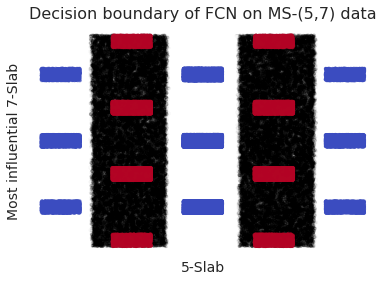

In [6]:
"""
Two-dimensional projection of the model's decision boundary
onto the two most influential coordinates (measured using randomized AUC)
"""
print ("Coordinate-wise randomized accuracies:")
ax = lms_utils.visualize_boundary(model, data, 0, 1, 50, ax=None, width=1, unif_k=True, k=100_000, print_info=True)
utils.update_ax(ax, 'Decision boundary of FCN on MS-(5,7) data', '5-Slab', 'Most influential 7-Slab', 
                title_fs=16, label_fs=14, legend_loc=False)
sns.despine(ax=ax, bottom=True, left=True); ax.set_xticks([]); ax.set_yticks([])
None

Accuracy on Perturbed Data: 0.00000
Mean Fraction of Budget in Simpler 5-Slab Coordinate: 0.99094


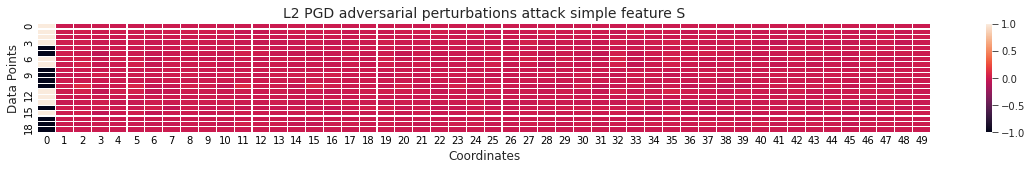

In [7]:
"""
Instance-specific adversarial attack (e.g., L2 PGD perturbations)
exclusively perturb feature S (5-slab coordinate in MS-{5,7}) 
"""
# compute perturbation
bounds = (data['X'].min().item(), data['X'].max().item())
drange = bounds[1]-bounds[0]
attack = pu.L2_PGD_Attack(0.5*drange, 0.05*drange, 20, 'untargeted', device=DEVICE, bounds=bounds)
attack_eval = attack.evaluate_attack(data['te_dl'], model)

# rotate perturbation and visualize mass in each coordinate(undo random transformation)
P = attack_eval['P'].dot(W.T)
Pn = P/np.max(np.abs(P), axis=1).reshape(-1,1)

# budget in linear
linear_ratio = np.abs(P[:,0])/np.linalg.norm(P, axis=1)

print ("Accuracy on Perturbed Data: {:.5f}".format(attack_eval['acc']))
print ("Mean Fraction of Budget in Simpler 5-Slab Coordinate: {:.5f}".format(np.mean(linear_ratio)))

fig, ax = plt.subplots(1,1,figsize=(20,2))
sns.heatmap(Pn[:20], linewidth=0.1, ax=ax) 
utils.update_ax(ax, 'L2 PGD adversarial perturbations attack simple feature S', 'Coordinates', 'Data Points', despine=False, legend_loc=False)

Accuracy on Perturbed Data: 0.06560
Mean Fraction of Budget in Simpler 5-Slab Coordinate: 0.99094


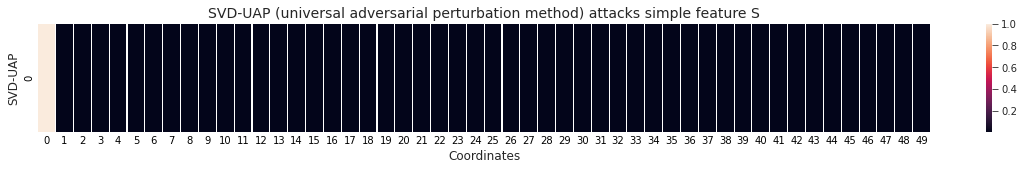

In [8]:
"""
Instance-agnostic "universal" adversarial perturbations exclusively attacks 
the simple feature S (5-slab coordinate in MS-{5,7}) as well. We show that 
SVD UAPs (https://arxiv.org/abs/2005.08632) and AS UAPs (Algorithm 2 in https://arxiv.org/abs/1811.11304)
"""

# SVD UAP (https://arxiv.org/abs/2005.08632)
bounds = (data['X'].min().item(), data['X'].max().item())
drange = bounds[1]-bounds[0]
attack = pu.L2_PGD_Attack(0.5*drange, 0.05*drange, 50, 'untargeted', device=DEVICE, bounds=bounds)
svd_uap = pu.SVD_UAP(attack, bounds=bounds, device=DEVICE)
svd_uap.fit(data['te_dl'], model)
attack_eval = svd_uap.evaluate_attack(data['te_dl'], model, eps=0.5)

# analyze UAP
UAP = svd_uap.uap.dot(W.T)
UAPn = np.abs(UAP)/np.max(np.abs(UAP))

print ("Accuracy on Perturbed Data: {:.5f}".format(attack_eval['acc']))
print ("Mean Fraction of Budget in Simpler 5-Slab Coordinate: {:.5f}".format(np.mean(linear_ratio)))

fig, ax = plt.subplots(1,1,figsize=(20,2))
sns.heatmap(UAPn.reshape(1,-1), linewidth=0.1, ax=ax) 
utils.update_ax(ax, 'SVD-UAP (universal adversarial perturbation method) attacks simple feature S', 'Coordinates', 'SVD-UAP', despine=False, legend_loc=False)

Accuracy on Perturbed Data: 0.06560
Mean Fraction of Budget in Simpler 5-Slab Coordinate: 0.99094


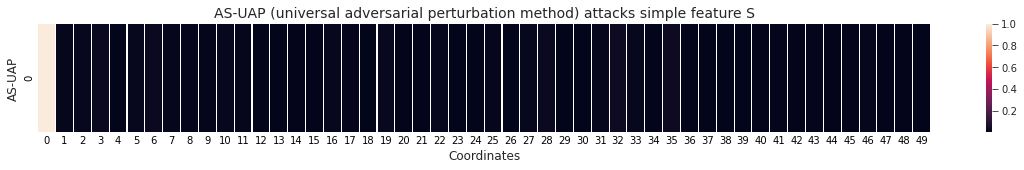

In [9]:
# AS UAP (https://arxiv.org/abs/1811.11304)
bounds = (data['X'].min().item(), data['X'].max().item())
drange = bounds[1]-bounds[0]

as_uap = pu.L2_AS_UAP(0.5, 0.05, 50, (50,), bounds=bounds, device=DEVICE)
as_uap.fit(data['te_dl'], model, num_epochs=2)
attack_eval = as_uap.evaluate_attack(data['te_dl'], model)

# analyze UAP
UAP = as_uap.uap.dot(W.T)
UAPn = np.abs(UAP)/np.max(np.abs(UAP))

print ("Accuracy on Perturbed Data: {:.5f}".format(attack_eval['acc']))
print ("Mean Fraction of Budget in Simpler 5-Slab Coordinate: {:.5f}".format(np.mean(linear_ratio)))

fig, ax = plt.subplots(1,1,figsize=(20,2))
sns.heatmap(UAPn.reshape(1,-1), linewidth=0.1, ax=ax) 
utils.update_ax(ax, 'AS-UAP (universal adversarial perturbation method) attacks simple feature S', 'Coordinates', 'AS-UAP', despine=False, legend_loc=False)

As shown above, L2 PGD perturbations and data-agnostic UAPs (computed using SVD-UAP and AS-UAP) drive down the accuracy from $100\%$ to $0-5\%$ by only targeting the simpler 5-slab coordinate on which trained models exclusively rely on (due to extreme SB).